# Predicting the Goldstein scale rating of events from their actors and coverage
This example workflow demonstrates the use of cuDF, cuML, and dask_cudf for ETL, model training, and evaluation

# Acquiring and Loading the Data
The [GDELT](https://www.gdeltproject.org/) project maintains a publically available 50TB database of world events. This workflow uses a sample of the data obtained through [Google BigQuery](https://console.cloud.google.com/marketplace/details/the-gdelt-project/gdelt-2-events)

We work with a ~5.7GB sample of the data stored locally. With appropriate Google Cloud credentials, the [gcs python api](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries) can be used to query the data directly without using a local copy. The GDELT project provides [a codebook](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf) to help us understand the dataset's schema

In [1]:
import dask_cudf
import cudf
from os.path import join

# The location of our local copy
DATA_DIR = "/datasets/gdelt/events/"

# Define the schema for the dataset. Normally dask_cudf can infer these types, however
# it does this on a per-file basis. Some of our features are so sparse that all entries 
# within a file are null, making it impossible to infer the data type
dtypes = (
    ["int64"] * 4
    + ["float64"]
    + ["str"] * 20
    + ["int64"]
    + ["str"] * 3
    + ["int64"]
    + ["float64"]
    + ["int64"] * 3
    + ["float64"]
    + ["int64"]
    + ["str"] * 4
    + ["float64"] * 2
    + ["str"]
    + ["int64"]
    + ["str"] * 4
    + ["float64"] * 2
    + ["str"]
    + ["int64"]
    + ["str"] * 4
    + ["float64"] * 2
    + ["str"]
    + ["int64"]
    + ["str"]
)

# The dataset was partitioned into ~2000 csv files. Let's load a subset of those
df = dask_cudf.read_csv(join(DATA_DIR, "00000000189*"), dtype=dtypes).compute()

In [2]:
# What did that give us?
print(f"Found {len(df)} rows")
print(f"Memory footprint: {df.__sizeof__() / (1024 * 1024):.2f} MB")
print(df.columns)

Found 8950745 rows
Memory footprint: 1631.46 MB
Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
  

# Preprocessing
We don't need all or even most of these columns

In [3]:
# Rather than listing the columns we don't want, let's list the ones we do
keep_cols = (
    "EventCode",
    "QuadClass",
    "GoldsteinScale",
    "NumMentions",
    "NumSources",
    "NumArticles",
    "AvgTone",
    "Actor1Type1Code",
    "Actor1Type2Code",
    "Actor1Type3Code",
    "Actor2Type1Code",
    "Actor2Type2Code",
    "Actor2Type3Code",
    "ActionGeo_CountryCode",
    "Actor1Geo_CountryCode",
    "Actor2Geo_CountryCode",
)
# And drop everything else
df = df.drop(col for col in df.columns if col not in keep_cols)

## Actor metadata
These codes tell us who, what, and where the relevant actors in the event are.

If we look at the codebook, we see that a lot of these features are categorical string labels. CuML can transform these into numerical values for us

In [4]:
from cuml.preprocessing import LabelEncoder

le = LabelEncoder()
for col in (
    "Actor1Type1Code",
    "Actor1Type2Code",
    "Actor1Type3Code",
    "Actor2Type1Code",
    "Actor2Type2Code",
    "Actor2Type3Code",
    "ActionGeo_CountryCode",
    "Actor1Geo_CountryCode",
    "Actor2Geo_CountryCode",
):
    df[col] = le.fit_transform(df[col])

In [5]:
print(df["Actor1Type1Code"].value_counts())

0    4896908
13    1214102
6     339424
5     317936
8     291539
10     273116
20     255840
22     239862
23     214759
24     192015
[27 more rows]
dtype: int64


## QuadClass
An event's `QuadClass` categorizes it as relating to either **verbal cooperation**, **material cooperation**, **verbal conflict**, or **material conflict**

The data is still a bit messy. Despite what the codebook says, `QuadClass` has a huge outlier we need to clean up. Let's also one-hot encode it to preserve the orthogonality of the categories

*Incidentally, it looks like verbal cooperation was the most common category, which is always nice to see*

In [6]:
print(df["QuadClass"].value_counts())

1    5504571
4    1227629
3    1178550
2    1039992
28702269          1
dtype: int64


In [7]:
from cudf import get_dummies

# We can fix that by clipping the data to our known range
df["QuadClass"] = df["QuadClass"].applymap(lambda i: min(i, 4))
df["QuadClass"] = df["QuadClass"].applymap(lambda i: max(i, 1))

# Now we one hot encode and drop the old column
df = get_dummies(df, columns=["QuadClass"]).drop("QuadClass")

In [8]:
print(df.columns)

Index(['Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'EventCode',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_CountryCode', 'Actor2Geo_CountryCode',
       'ActionGeo_CountryCode', 'QuadClass_1', 'QuadClass_2', 'QuadClass_3',
       'QuadClass_4'],
      dtype='object')


## Normalization
- `NumArticles`, `NumSources`, and `NumMentions` tell us the number of source documents, information sources, and mentions across sources that an event recieved within 15 minutes of being discovered by the database. We can use this as a proxy for the importance or impact of an event
- `AvgTone` describes the tone of the above documents towards the event, on a scale from -100 (extremely negative) to 100 (extremely positive)
- `GoldsteinScale` is our target variable. It serves as a way of quantifying the intensity of positive and negative events.

It looks like these variables are filled with `null` values

In [9]:
for col in ("NumArticles", "NumSources", "NumMentions", "AvgTone", "GoldsteinScale"):
    print(f"{col}: {df[col].isna().value_counts()[True]}")

NumArticles: 2
NumSources: 2
NumMentions: 2
AvgTone: 2
GoldsteinScale: 42


Proportionally there aren't that many `null`s, so we can reasonably replace them with the average feature values. While we're here, let's also remove any outliers from our target variable

In [10]:
df["AvgTone"] = df["AvgTone"].fillna(df["AvgTone"].mean())

df["GoldsteinScale"] = df["GoldsteinScale"].applymap(lambda i: min(i, 10))
df["GoldsteinScale"] = df["GoldsteinScale"].applymap(lambda i: max(i, -10))
df["GoldsteinScale"] = df["GoldsteinScale"].fillna(df["GoldsteinScale"].mean())

df["NumMentions"] = (
    df["NumMentions"].astype("float64").fillna(df["NumMentions"].mean())
)
df["NumSources"] = (
    df["NumSources"].astype("float64").fillna(df["NumSources"].mean())
)
df["NumArticles"] = (
    df["NumArticles"].astype("float64").fillna(df["NumArticles"].mean())
)

We'll also want to min/max scale `NumSources`, `NumArticles`, and `NumMentions` to maintain consistency with our other features

In [11]:
for col in (
    "NumMentions",
    "NumSources",
    "NumArticles",
):
    col_max = df[col].max()
    col_min = df[col].min()
    if col_max != col_min:
        df[col] = (df[col] - df[col].mean()) / (col_max - col_min)

Before we give cuML our data, we need to ensure all columns have the same dtype

In [12]:
for col in filter(lambda col: df[col].dtype != "float64", df):
    df[col] = df[col].astype("float64")

# Model Training and Evaluation
Now we can run and score our regression. To do this we'll have to

- define our performance metrics
- split our data into train and test sets
- train and test our model

In [13]:
# As our performance metrics we'll use a basic mean squared error and coefficient of determination implementation
def mse(y_test, y_pred):
    return ((y_test - y_pred) ** 2).mean()

def cod(y_test, y_pred):
    y_bar = y_test.mean()
    total = ((y_test - y_bar) ** 2).sum()
    residuals = ((y_test - y_pred) ** 2).sum()
    return 1 - (residuals / total)

With the help of cuML we can abstract away most of the train/test process

In [14]:
from cuml.preprocessing.model_selection import train_test_split
from cuml.linear_model.ridge import Ridge

def train_and_score(data, clf, train_frac=0.8, n_runs=20):
    mse_scores, cod_scores = [], []
    for _ in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            data, y="GoldsteinScale", train_size=train_frac
        )
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        mse_scores.append(mse(y_test, y_pred))
        cod_scores.append(cod(y_test, y_pred))
    return mse_scores, cod_scores

# Results
Let's see how our model performs

In [15]:
import numpy as np
n_runs = 20
clf = Ridge()
mse_scores, cod_scores = train_and_score(df, clf, n_runs=n_runs)
print(f"median MSE ({n_runs} runs): {np.median(mse_scores)}")
print(f"median COD ({n_runs} runs): {np.median(cod_scores)}")

median MSE (20 runs): 5.036132676165211
median COD (20 runs): 0.7674086552283645


Reasonably good correlation, though the MSE leaves a bit to be desired. Predicting a value on the Goldstein scale within ~2.24 points is nice, until you remember our values are in \[-10, 10\]. Let's try some more intelligent analysis. For instance, what does the learning curve for this model look like?

In [16]:
clf = Ridge()
n_runs = 10
train_sizes = np.arange(0.0001, 0.91, 0.05)
scores = [np.median(train_and_score(df, clf, train_frac=s, n_runs=n_runs)[0])
          for s in train_sizes]
print(f"Variance: {np.var(scores)}")

Variance: 0.00019863536617650075


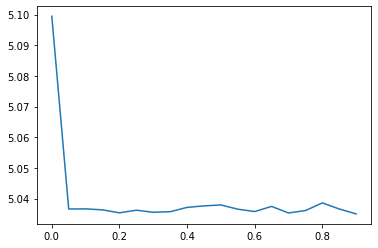

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_sizes, scores)
plt.show()

Interestingly, our loss changes very little when given 10% of the data or 90% of the data. Were we to deploy this model, satisfied with it's performance, we could comfortably train it on only ~890,000 instances (for an even greater speedup) with minimal performance loss.

# Performance
On our 5.7GB sample of the dataset which consisted of ~8.9 million rows, this notebook takes 2.5 minutes to run from start to finish. Recall that this includes
- ETL
- Preprocessing and feature engineering, with feature encoding and rescaling
- Training and inference for a total of 190 ridge regressors

In the same amount of time, the equivalent pandas/scikit-learn implementation barely finishes its etl phase.

# The key takeaways
With cuDF, cuML, and dask_cudf, we're able to 
- explore large datasets
- quickly analyze and transform our data
- train and evaluate models

with minimal changes to our existing pandas, scikit-learn, and dask powered workflows, and see drastic improvements in performance, making it easier to build scalable data science pipelines without sacrificing performance